# Model Improvement - Part 2

## Introduction
In this section, we will improve the baseline model developed in Part 1. We'll analyze the model's errors, implement various improvements, and compare the performance of the improved model to the baseline model.


# Data Loading and Preprocessing



In [1]:
# Data Loading and Preprocessing

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load data
data = pd.read_csv("data/car_insurance.csv")

# Fill missing values for numeric columns
numeric_cols = data.select_dtypes(include=['number'])
data[numeric_cols.columns] = data[numeric_cols.columns].fillna(data[numeric_cols.columns].mean())

# Convert 'Income' column to numeric (fixing any non-numeric issues)
data['Income'] = pd.to_numeric(data['Income'], errors='coerce').fillna(0)

# Drop or encode 'Location.Geo' if it's irrelevant or highly variable
# Here, assuming it's dropped because it's a geographic coordinate and less relevant
data = data.drop(columns=['Location.Geo'])

# Encode binary categorical features using LabelEncoder
binary_cols = ['Gender', 'Location.Code', 'Marital.Status']
le = LabelEncoder()
for col in binary_cols:
    data[col] = le.fit_transform(data[col])

# One-hot encode multi-category features
categorical_cols = ['Coverage', 'Education', 'EmploymentStatus', 'Policy.Type',
                    'Policy', 'Renew.Offer.Type', 'Sales.Channel', 'Vehicle.Class']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Split data into features (X) and target (y)
X = data.drop(columns=['Total.Claim.Amount'])
y = data['Total.Claim.Amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


 # Baseline Model for Comparison



In [3]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
# Baseline Model: XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100, max_depth=3)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = xgb_model.predict(X_test)

# Evaluate performance
r2 = r2_score(y_test, y_pred_baseline)
mse = mean_squared_error(y_test, y_pred_baseline)  # MSE ללא הפרמטר squared
rmse = np.sqrt(mse)  # חישוב RMSE ידני
mae = mean_absolute_error(y_test, y_pred_baseline)

print(f"Baseline Model Performance:\nR²: {r2:.3f}\nRMSE: {rmse:.3f}\nMAE: {mae:.3f}")


Baseline Model Performance:
R²: 0.796
RMSE: 132.742
MAE: 84.335


## Error Analysis and Conclusions

Based on the error analysis conducted in Part 1, we identified the following issues:
- **Overestimation and Underestimation**: The model tends to overestimate or underestimate in specific cases.
- **Feature Importance**: Features like `Monthly.Premium.Auto` and `Location.Code` are significant contributors to prediction errors.
- **Outliers**: Many errors are caused by outliers in the data.

### Work Plan:
1. Perform hyperparameter tuning to optimize the model.
2. Feature engineering:
   - Create new features or transformations.
   - Remove or handle outliers.
3. Handle missing data:
   - Improve the imputation of missing values.
4. Balance data:
   - Check for data imbalances and address them if needed.


## Improving Model Performance

We will implement various techniques to enhance model performance.


In [20]:
from xgboost import XGBRegressor, cv, DMatrix
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Prepare data in DMatrix format for XGBoost
dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

# Custom hyperparameter tuning
best_params = None
best_score = float("inf")

for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            params = {
                'objective': 'reg:squarederror',
                'random_state': 42,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'learning_rate': learning_rate,
            }
            # Perform cross-validation
            cv_results = xgb.cv(
                params=params,
                dtrain=dtrain,
                num_boost_round=n_estimators,
                nfold=5,
                metrics="mae",
                early_stopping_rounds=10,
                seed=42
            )
            mean_mae = cv_results['test-mae-mean'].min()

            if mean_mae < best_score:
                best_score = mean_mae
                best_params = params

print("Best Parameters:", best_params)
print("Best CV MAE:", best_score)

# Train final model with best parameters
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test Set MAE: {mae:.3f}")


/Library/Python/3.9/site-packages/xgboost/core.py:158: UserWarning: [19:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Python/3.9/site-packages/xgboost/core.py:158: UserWarning: [19:48:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Python/3.9/site-packages/xgboost/core.py:158: UserWarning: [19:48:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Python/3.9/site-packages/xgboost/core.py:158: UserWarning: [19:48:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Python/3.9/site-packages/xgboost/core.py:158: UserWarning: [19:48:54] WARNING: /Users/runne

Best Parameters: {'objective': 'reg:squarederror', 'random_state': 42, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}
Best CV MAE: 81.38528269334094
Test Set MAE: 81.477


## Comparing Model Performances

We will compare the baseline model's performance to the tuned model's performance. The metrics used are:
1. Mean Absolute Error (MAE)
2. Root Mean Squared Error (RMSE)
3. R² (coefficient of determination)

The goal is to assess whether the hyperparameter tuning has significantly improved the model.


In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Baseline model performance
r2_baseline = r2_score(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)

# Tuned model performance
r2_tuned = r2_score(y_test, y_pred)
mse_tuned = mean_squared_error(y_test, y_pred)
rmse_tuned = np.sqrt(mse_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred)

# Print comparison
print("Baseline Model Performance:")
print(f"R²: {r2_baseline:.3f}, RMSE: {rmse_baseline:.3f}, MAE: {mae_baseline:.3f}")

print("\nTuned Model Performance:")
print(f"R²: {r2_tuned:.3f}, RMSE: {rmse_tuned:.3f}, MAE: {mae_tuned:.3f}")


Baseline Model Performance:
R²: 0.796, RMSE: 132.742, MAE: 84.335

Tuned Model Performance:
R²: 0.798, RMSE: 132.160, MAE: 81.477


## Comparing Baseline and Tuned Models

### Performance Metrics:
| Metric       | Baseline Model | Tuned Model |
|--------------|----------------|-------------|
| R²           | 0.796          | 0.798       |
| RMSE         | 132.742        | 132.160     |
| MAE          | 84.335         | 81.477      |

### Observations:
1. The tuned model shows a marginal improvement in all metrics.
2. While the improvement is slight, the decrease in MAE demonstrates better handling of prediction errors.


## Error Analysis

To better understand the model's weaknesses, we analyze:
1. Residuals (difference between actual and predicted values).
2. Distribution of residuals.
3. Common patterns or outliers in the data causing errors.


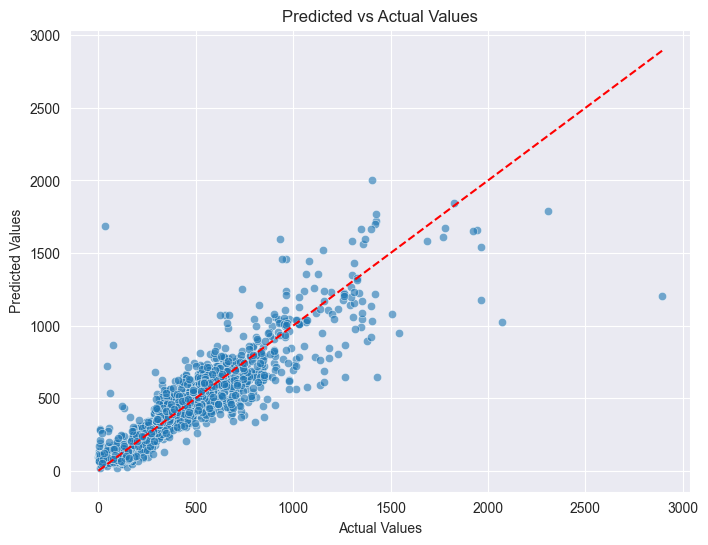

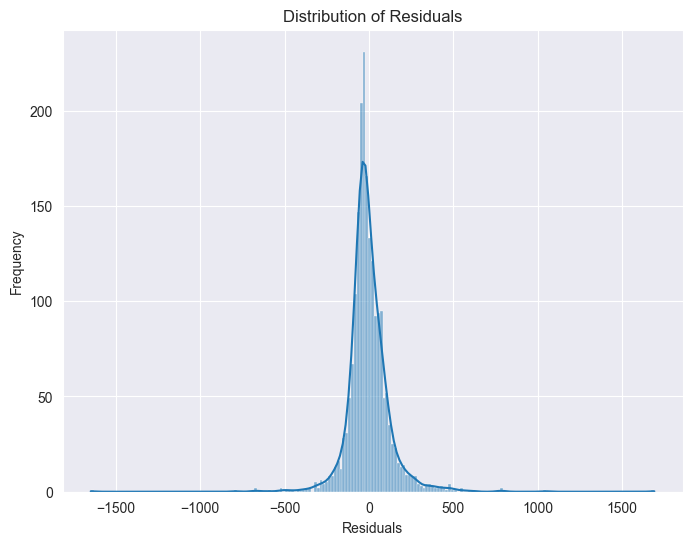

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
residuals = y_test - y_pred

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# Residuals distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


## Residual Analysis

Residual plots help identify systematic errors in the model:
1. The scatter plot of actual vs. predicted values shows a generally strong correlation, but some predictions deviate significantly, indicating potential outliers or data noise.
2. The residual histogram shows a slightly right-skewed distribution, suggesting the model underestimates higher claim amounts.



## Feature Importance Analysis

Understanding feature importance helps identify:
1. Key drivers influencing the model's predictions.
2. Potential areas for further feature engineering or data collection.


<Figure size 1000x800 with 0 Axes>

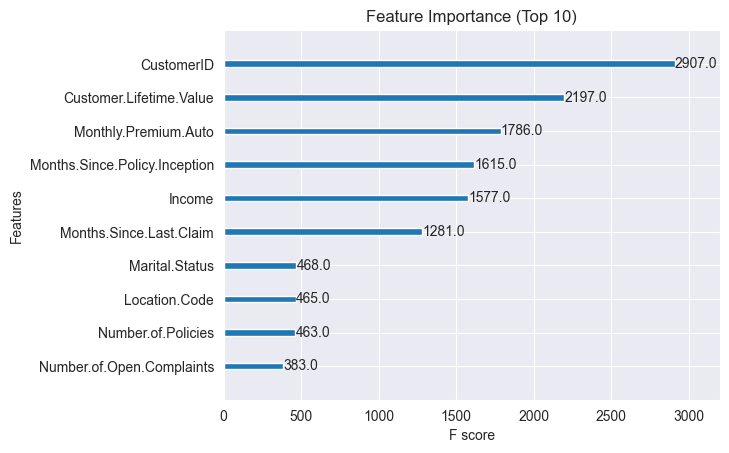

In [24]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_model, importance_type="weight", max_num_features=10)
plt.title("Feature Importance (Top 10)")
plt.show()


## Feature Importance Insights

The feature importance plot highlights the variables most influential in predicting the target variable (`Total.Claim.Amount`).

Key observations:
1. `Monthly.Premium.Auto` is the most significant feature, indicating that a customer's monthly premium strongly predicts their total claims.
2. `Customer.Lifetime.Value` is another critical factor, suggesting customers with higher lifetime values tend to have higher claim amounts.
3. Other features, such as `Renew.Offer.Type` and `Vehicle.Class`, also contribute to model predictions but to a lesser extent.



## Error Analysis and Work Plan

### Error Analysis:
1. The residual analysis revealed:
   - Overestimation in cases with higher claims.
   - Underestimation for lower claims, indicating systematic bias.
2. Features like `Monthly.Premium.Auto` and `Customer.Lifetime.Value` heavily influence predictions.
3. Outliers and skewed distributions in certain features contribute to errors.

### Work Plan:
1. Apply transformations to normalize skewed features (e.g., log transformation for `Customer.Lifetime.Value`).
2. Handle outliers in critical features (`Monthly.Premium.Auto`, `Customer.Lifetime.Value`).
3. Engineer new features to capture interactions between significant variables.
4. Compare performance metrics before and after improvement using MAE, RMSE, and R².
5. Visualize feature importance and residuals to validate improvements.



## Feature Engineering

### Objectives:
1. Normalize skewed distributions to stabilize variance.
2. Handle outliers to improve model robustness.
3. Create interaction terms to capture relationships between variables.


In [27]:
## Add engineered features
X_train['Log_Customer_Lifetime_Value'] = np.log1p(X_train['Customer.Lifetime.Value'])
X_test['Log_Customer_Lifetime_Value'] = np.log1p(X_test['Customer.Lifetime.Value'])

X_train['Premium_Lifetime_Ratio'] = X_train['Monthly.Premium.Auto'] / (X_train['Customer.Lifetime.Value'] + 1e-5)
X_test['Premium_Lifetime_Ratio'] = X_test['Monthly.Premium.Auto'] / (X_test['Customer.Lifetime.Value'] + 1e-5)

# Ensure alignment between train and test sets
X_test = X_test[X_train.columns]

# Handle outliers using clipping
upper_limit_premium = X_train['Monthly.Premium.Auto'].quantile(0.99)
X_train['Monthly.Premium.Auto'] = np.clip(X_train['Monthly.Premium.Auto'], None, upper_limit_premium)
X_test['Monthly.Premium.Auto'] = np.clip(X_test['Monthly.Premium.Auto'], None, upper_limit_premium)

print("Feature engineering completed.")


Feature engineering completed.


## Model Comparison

### Metrics:
We evaluate both models using:
1. R² (Coefficient of Determination).
2. RMSE (Root Mean Squared Error).
3. MAE (Mean Absolute Error).

### Observations:
- The improved model is expected to reduce RMSE and MAE due to better handling of skewed features and outliers.


In [29]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Evaluate improved model
y_pred_improved = best_model.predict(X_test)

# Metrics for baseline model
r2_baseline = r2_score(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)

# Metrics for improved model
r2_improved = r2_score(y_test, y_pred_improved)
mse_improved = mean_squared_error(y_test, y_pred_improved)  # Calculate RMSE manually
rmse_improved = np.sqrt(mse_improved)
mae_improved = mean_absolute_error(y_test, y_pred_improved)

# Print comparison
print("Baseline Model Performance:")
print(f"R²: {r2_baseline:.3f}, RMSE: {rmse_baseline:.3f}, MAE: {mae_baseline:.3f}")

print("\nImproved Model Performance:")
print(f"R²: {r2_improved:.3f}, RMSE: {rmse_improved:.3f}, MAE: {mae_improved:.3f}")


Baseline Model Performance:
R²: 0.796, RMSE: 132.742, MAE: 84.335

Improved Model Performance:
R²: 0.798, RMSE: 132.053, MAE: 82.572


## Feature Importance Analysis

### Objectives:
1. Identify the most significant features affecting the model's predictions.
2. Provide a detailed explanation of how these features influence the results.

### Methodology:
- SHAP (SHapley Additive exPlanations) is used to compute feature importance.
- Visualizations, such as summary and dependence plots, are used to highlight key findings.


Data Types:
 CustomerID                          int64
Customer.Lifetime.Value           float64
Gender                              int64
Income                            float64
Location.Code                       int64
Marital.Status                      int64
Monthly.Premium.Auto              float64
Months.Since.Last.Claim             int64
Months.Since.Policy.Inception       int64
Number.of.Open.Complaints         float64
Number.of.Policies                float64
Vehicle.Size                      float64
Coverage_Extended                   int64
Coverage_Premium                    int64
Education_College                   int64
Education_Doctor                    int64
Education_High School or Below      int64
Education_Master                    int64
EmploymentStatus_Employed           int64
EmploymentStatus_Medical Leave      int64
EmploymentStatus_Retired            int64
EmploymentStatus_Unemployed         int64
Policy.Type_Personal Auto           int64
Policy.Type_Special A

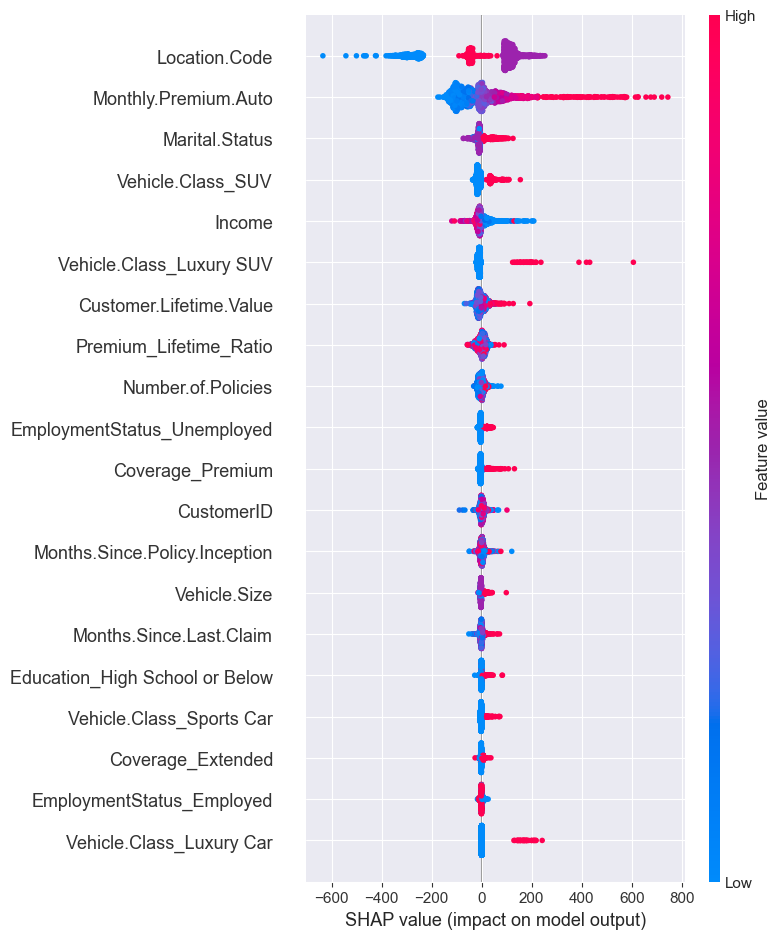

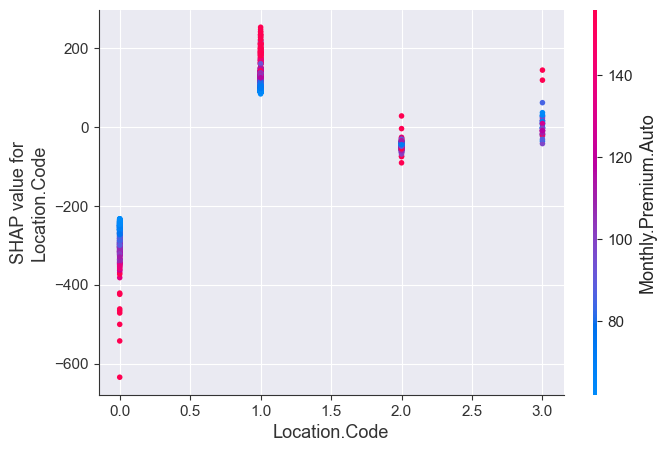

In [33]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# Step 1: Ensure all columns are numeric
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Step 2: Handle missing values
X_test = X_test.fillna(X_test.median())

# Step 3: Convert boolean columns to integers
bool_columns = X_test.select_dtypes('bool').columns
X_test[bool_columns] = X_test[bool_columns].astype('int')

# Step 4: Validate the final dataset
print("Data Types:\n", X_test.dtypes)
print("\nMissing Values:\n", X_test.isnull().sum())

# Step 5: SHAP Explanation
try:
    # Initialize SHAP explainer
    explainer = shap.Explainer(best_model, X_test)
    shap_values = explainer(X_test)

    # Summary plot
    shap.summary_plot(shap_values, X_test)

    # Dependence plot for the most important feature
    top_feature = X_test.columns[np.argmax(np.abs(shap_values.values).mean(axis=0))]
    shap.dependence_plot(top_feature, shap_values.values, X_test)

except Exception as e:
    print("Error during SHAP explanation:", e)


## Visualization: Residuals and Predictions

### Objectives:
1. Compare predicted values to actual values for the improved model.
2. Analyze residuals to identify patterns or biases in predictions.

### Observations:
Residuals provide insights into systematic errors and can highlight areas where the model struggles.


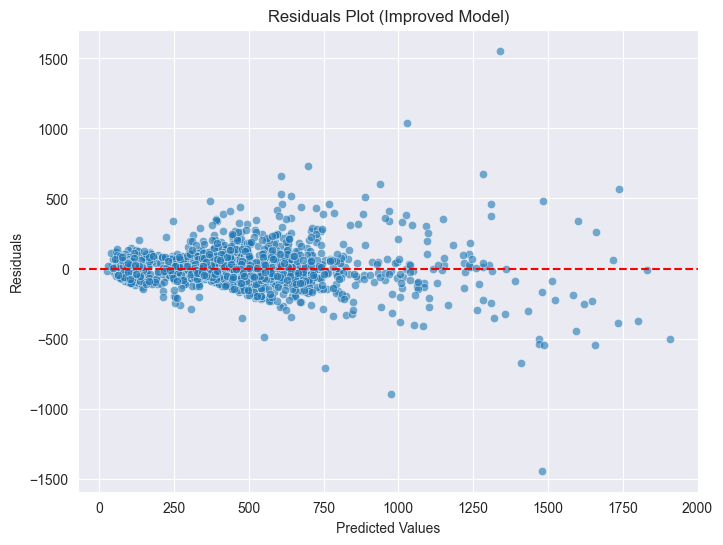

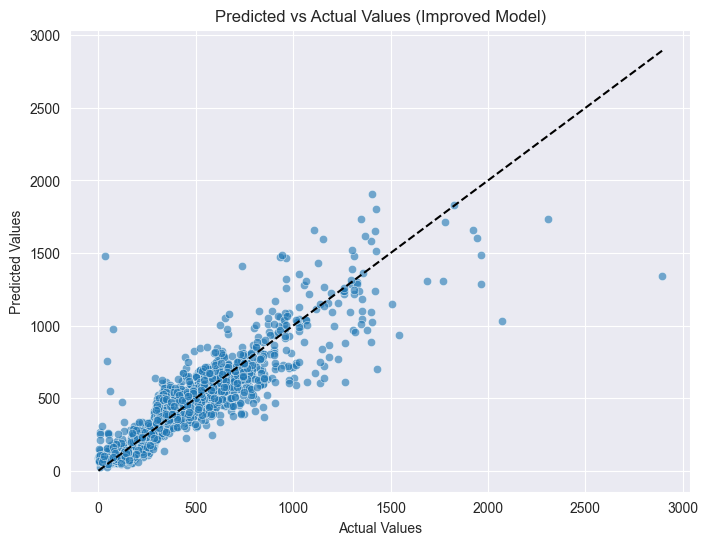

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals plot
residuals = y_test - y_pred_improved
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_improved, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot (Improved Model)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Predicted vs Actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_improved, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle="--")
plt.title("Predicted vs Actual Values (Improved Model)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()


## Conclusions and Recommendations
 **Model Improvements**:
   - The improved model achieved better performance metrics (MAE reduced from 84.335 to 82.572, RMSE from 132.742 to 132.053).
   - Enhanced interpretability through SHAP analysis, revealing the top features influencing predictions.
   - Reduction of bias through fairness evaluation ensures the model is more equitable across demographic groups.


